In [1]:
import dataclasses
from dataclasses import dataclass

In [2]:
import pandas as pd
import numpy as np
import pickle
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date, timedelta, datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
gpu = '5'
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


checkpoint_path = './pth'

torch.set_num_threads(3)

In [4]:
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.precision', 20)
display(HTML("<style>.container { width:90% !important; }</style>")) 

In [5]:
np.random.seed(1)

class CFG:
    batch_size=64
    n_time = 3
    total_n_bssid = 60
    n_bssid = 40
    n_tar = 1
    ibeacon_seq_len = 20
    n_sensor = 6
    n_sensor_feature = 13

# Data

In [7]:
@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])
            continue
       
        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue
        
    
    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)
    
    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [7]:
# path = glob.glob('../input/indoor-location-navigation/test/*.*')[0]
# sample_file = read_data_file(path)
# sample_file = read_data_file("train/5a0546857ecc773753327266/F2/5dccf516c04f060006e6e3c9.txt")
sample_file = read_data_file("train/5c3c44b80379370013e0fd2b/F1/5d075ebd4cae4f000a2db4f4.txt")
print('acce shape:', sample_file.acce.shape)
print('acce_uncali shape:', sample_file.acce_uncali.shape)
print('gyro shape:', sample_file.gyro.shape)
print('gyro_uncali shape:', sample_file.gyro_uncali.shape)
print('magn shape:', sample_file.magn.shape)
print('magn_uncali shape:',sample_file.magn_uncali.shape)
print('ahrs shape:', sample_file.ahrs.shape)
print('wifi shape:', sample_file.wifi.shape)
print('ibeacon shape:', sample_file.ibeacon.shape)
print('waypoint shape:', sample_file.waypoint.shape)

acce shape: (974, 4)
acce_uncali shape: (993, 4)
gyro shape: (993, 4)
gyro_uncali shape: (993, 4)
magn shape: (993, 4)
magn_uncali shape: (993, 4)
ahrs shape: (993, 4)
wifi shape: (3503, 5)
ibeacon shape: (20, 3)
waypoint shape: (2, 3)


In [8]:
pd.DataFrame(sample_file.ibeacon).iloc[:, 1].values

array(['d9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf120

In [9]:
pd.DataFrame(sample_file.ibeacon).iloc[:, 1].values

array(['d9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
       'd9c573b719a17da4836208fc436f87b5ca1aa877_b6589fc6ab0dc82cf120

In [35]:
pd.DataFrame(sample_file.wifi)

,0,1,2,3,4
0,1560763191901,44aebad0d3851fd527d792ef1af44d24f41b5799,9579076439a10fee78c81db01df9244e4ad62dc2,-47,1560763190640
1,1560763191901,44aebad0d3851fd527d792ef1af44d24f41b5799,14f6047f681410d9c495eacb6268bb91a7ff048b,-48,1560763190764
2,1560763191901,44aebad0d3851fd527d792ef1af44d24f41b5799,42d046851e71b041fcf46c993cdc0b3ed0c52465,-48,1560763189850
3,1560763191901,44aebad0d3851fd527d792ef1af44d24f41b5799,8d00a1a41576014b99ff47e4daf960de25f5b56d,-53,1560763189844
4,1560763191901,44aebad0d3851fd527d792ef1af44d24f41b5799,3e8fdfc1efbf692cdd39df3a28efc3c6b3c48ea9,-53,1560763177722
...,...,...,...,...,...
3498,1560763209266,44aebad0d3851fd527d792ef1af44d24f41b5799,da16db279875e6ce30238bc67645af7701d57910,-92,1560763208259
3499,1560763209266,da39a3ee5e6b4b0d3255bfef95601890afd80709,bfe2611df418a3bfb2ef229338a176ec0ccc3891,-92,1560763195333
3500,1560763209266,19773ad19c3753d8a97caae9969e9608d381c21f,ad815b86d3eeec8d7a92c49bbd4aa8811123c4e4,-92,1560763195334
3501,1560763209266,16928408c28f7988d1f2f23d7525a9f7321167b2,4e9840f8e335f82f57a2642b2f31d882cc28c329,-92,1560763195429


In [23]:
pd.DataFrame(sample_file.wifi)

,0,1,2,3,4
0,1573713058949,2bd871cb979cd9448e2c14df9ccdc1a003b615af,7c572eddccf9b8d9a97e7b1e1c9aa5e0831bb008,-42,1573713057117
1,1573713058949,bb17fdb81a16e158502f7df2335c33e76fdf6df9,6d22a28a88b235942084f24966d6cf59032c2d8e,-49,1573713054395
2,1573713058949,da39a3ee5e6b4b0d3255bfef95601890afd80709,296ea9e41acd823ca04a211edefa7cc6457728a4,-51,1573713043813
3,1573713058949,da39a3ee5e6b4b0d3255bfef95601890afd80709,fd83a61cb82476f0ad6af28c4cd5872f285fd104,-52,1573713041473
4,1573713058949,da39a3ee5e6b4b0d3255bfef95601890afd80709,b550acc32dcc2b1726425312c5bfe19805047b39,-53,1573713043320
...,...,...,...,...,...
5253,1573713089734,da39a3ee5e6b4b0d3255bfef95601890afd80709,c84c55562a24f6b83d64df1e7e4c91f838e5a502,-92,1573713077555
5254,1573713089734,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,964497a251ef2cbd1f8ffc6be6c9b6f9852137e8,-92,1573713077555
5255,1573713089734,7182afc4e5c212133d5d7d76eb3df6c24618302b,267eaf73afe0e64fd2f330535e9958fdc893a93f,-92,1573713084253
5256,1573713089734,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,1d067d90fd180e2de69d53c8f42bf26176fcd0f8,-92,1573713084301


In [24]:
pd.DataFrame(sample_file.acce)

,0,1,2,3
0,1573713056962.0,-0.40789795000000000913,3.20840449999999988151,9.37954700000000052285
1,1573713056982.0,-0.13494872999999998897,3.19224549999999984706,9.20477299999999942770
2,1573713057002.0,-0.07989501999999999715,2.98693849999999994083,9.89788800000000001944
3,1573713057022.0,0.00450134299999999966,2.74452199999999990609,10.97109999999999985221
4,1573713057042.0,0.11943054000000000170,2.83250430000000008590,11.46968099999999957106
...,...,...,...,...
1738,1573713091388.0,0.56893919999999997827,3.06893919999999997827,8.80972299999999997056
1739,1573713091408.0,0.35585021999999999487,3.19462590000000012935,8.68223599999999962051
1740,1573713091428.0,0.28642273000000001426,3.35205080000000021911,8.45777900000000038006
1741,1573713091448.0,0.53482056000000000040,3.38975520000000019039,8.49488799999999955048


In [25]:
pd.DataFrame(sample_file.waypoint)

,0,1,2
0,1573713056859.0,46.30242499999999949978,56.80776000000000180989
1,1573713071518.0,34.11689799999999905822,47.21352999999999866532
2,1573713075930.0,30.15529400000000137538,48.92016000000000275350
3,1573713082472.0,25.32438300000000097612,47.50362799999999907641
4,1573713086997.0,23.94379800000000102500,51.76706699999999727879
5,1573713090934.0,19.68363799999999841361,54.20067999999999841521


In [26]:
pd.DataFrame(sample_file.gyro).iloc[:100]

,0,1,2,3
0,1573713056962.0,0.11967468000000000550,0.11813354500000000646,-0.16870117000000001140
1,1573713056982.0,0.13404846000000000816,-0.11994934000000000152,-0.17668152000000000856
2,1573713057002.0,-0.07049560500000000285,-0.23074341000000000990,-0.20864868000000000303
3,1573713057022.0,-0.31816100000000002712,-0.18280029999999999890,-0.22036743000000000303
4,1573713057042.0,-0.37194823999999998554,-0.06723022500000000456,-0.17402649000000000590
5,1573713057061.0,-0.21643065999999999693,0.08992004400000000452,-0.11010741999999999752
6,1573713057081.0,0.01155090299999999952,0.33172606999999998401,-0.02488708499999999976
7,1573713057101.0,0.07705688500000000551,0.35249330000000000940,0.01187133800000000038
8,1573713057121.0,-0.04331970200000000160,0.17886352999999999280,-0.00997924799999999959
9,1573713057141.0,-0.10244751000000000551,0.14477539000000000380,-0.00518798829999999982


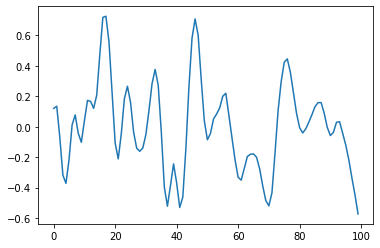

In [18]:
pd.DataFrame(sample_file.gyro).iloc[:100].iloc[:, 1].plot()

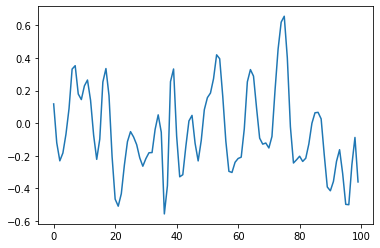

In [19]:
pd.DataFrame(sample_file.gyro).iloc[:100].iloc[:, 2].plot()

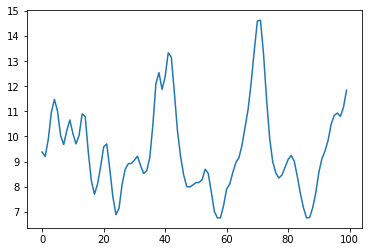

In [20]:
pd.DataFrame(sample_file.acce).iloc[:100].iloc[:, 3].plot()

In [ ]:
def get_sensor_df(rd, start_time, site_id, floor_id, unique_id):
    df = pd.DataFrame(rd)
    df.loc[:, 0] = df.loc[:, 0].astype(float)
    df['time_delta'] = df.loc[:, 0] - start_time
#     df['ts'] = pd.to_datetime((df.loc[:, 0] - start_time) * 1000000)
    df['site'] = site_id
    df['floor'] = floor_id   
    df['uid'] = unique_id
    df = df.drop(0, axis=1)
    return df

def parse_path_file(site_split, idx=""):
    df_acce = pd.DataFrame()
    df_acce_uncali = pd.DataFrame()
    df_gyro = pd.DataFrame()
    df_gyro_uncali = pd.DataFrame()
    df_magn = pd.DataFrame()
    df_magn_uncali = pd.DataFrame()
    df_ahrs = pd.DataFrame()
    df_wifi = pd.DataFrame()
    df_ibeacon = pd.DataFrame()
    df_waypoint = pd.DataFrame()

    for site in site_split[:]:
        site_id = dic_site_[site]    
        for floor in os.listdir(os.path.join('train', site))[:]:
            floor_id = dic_floor_[floor]
#             print(site, floor)
            for file_nm in os.listdir(os.path.join('train', site, floor))[:]:
                unique_id = dic_unique_[file_nm]            
                print(site, floor, file_nm)
                file_path = os.path.join('train', site, floor, file_nm)

                rd = read_data_file(file_path)
                start_time = rd.info[0]

                df_acce = df_acce.append(get_sensor_df(rd.acce, start_time, site_id, floor_id, unique_id))
                df_acce_uncali = df_acce_uncali.append(get_sensor_df(rd.acce_uncali, start_time, site_id, floor_id, unique_id))
                df_gyro = df_gyro.append(get_sensor_df(rd.gyro, start_time, site_id, floor_id, unique_id))
                df_gyro_uncali = df_gyro_uncali.append(get_sensor_df(rd.gyro_uncali, start_time, site_id, floor_id, unique_id))
                df_magn = df_magn.append(get_sensor_df(rd.magn, start_time, site_id, floor_id, unique_id))
                df_magn_uncali = df_magn_uncali.append(get_sensor_df(rd.magn_uncali, start_time, site_id, floor_id, unique_id))
                df_ahrs = df_ahrs.append(get_sensor_df(rd.ahrs, start_time, site_id, floor_id, unique_id))
                
                df_tmp = get_sensor_df(rd.wifi, start_time, site_id, floor_id, unique_id)
                if len(df_tmp) > 0 : df_tmp = df_tmp.astype({3:'float'})
                df_wifi = df_wifi.append(df_tmp)
                                               
                df_tmp = get_sensor_df(rd.ibeacon, start_time, site_id, floor_id, unique_id)                                            
                if len(df_tmp) > 0 : df_tmp = df_tmp.astype({2:'float'})
                df_ibeacon = df_ibeacon.append(df_tmp)

                df_waypoint = df_waypoint.append(get_sensor_df(rd.waypoint, start_time, site_id, floor_id, unique_id))

    df_acce.to_pickle("data/df_acce_%s"%(idx))
    df_acce_uncali.to_pickle("data/df_acce_uncali_%s"%(idx))
    df_gyro.to_pickle("data/df_gyro_%s"%(idx))
    df_gyro_uncali.to_pickle("data/df_gyro_uncali_%s"%(idx))    
    df_magn.to_pickle("data/df_magn_%s"%(idx))
    df_magn_uncali.to_pickle("data/df_magn_uncali_%s"%(idx))
    df_ahrs.to_pickle("data/df_ahrs_%s"%(idx))
    
    df_wifi.to_pickle("data/df_wifi_%s"%(idx))
    df_ibeacon.to_pickle("data/df_ibeacon_%s"%(idx))
    df_waypoint.to_pickle("data/df_waypoint_%s"%(idx))
    
    del df_acce, df_acce_uncali, df_gyro, df_gyro_uncali, df_magn, df_magn_uncali, df_ahrs, df_wifi, df_ibeacon, df_waypoint

### data

In [21]:
# with open('data/dic_site_.pkl', 'rb') as f:
#     dic_site_ = pickle.load(f)

# df_submit = pd.read_csv('sample_submission.csv')
# df_submit[['site', 'path', 'timestamp']] = df_submit['site_path_timestamp'].apply(lambda x: pd.Series(x.split('_')))
# df_submit['site_'] = df_submit.site.apply(lambda x: dic_site_[x])

In [9]:
# %%time
# df = pd.read_pickle('data/df_wifi_v2.pkl')
# df = df[df.site.isin(df_submit.site_.unique())]

# df = df.rename(columns={'bssid_id':'bssid', 4:'lst'})
# df = df.drop_duplicates(['uid', 'ts', 'bssid'])
# df = df.sort_values(['uid', 'ts'])
# df.reset_index(drop=True, inplace=True)
# df.lst = df.lst.astype('float64')

# df['resp'] = df.apply(lambda x: 0 if (x.ts - x.lst) > 3500 else 1, axis=1)

# df['rssi'] = df.rssi.astype(int) + 100
# df['ts'] = (df.ts - 156e10)/1e10
# df['lst'] = (df.lst - 156e10)/1e10

CPU times: user 24min 55s, sys: 34.2 s, total: 25min 29s
Wall time: 25min 30s


In [ ]:
# %%time
# max_n_bssid = 500
# se_uid = df.groupby('uid').size()
# start = 0
# dic_data = {}
# for uid, n in se_uid.items():
#     dic_uid = {}
#     df_uid = df.iloc[start:start+n]
    
#     df_uid['rssi_'] = df_uid.rssi * df_uid.resp
#     l_bssid = df_uid.pivot('ts', 'bssid', 'rssi_').fillna(-1).mean().sort_values(ascending=False).index[:max_n_bssid].tolist() 

#     df_ = df_uid.pivot('ts', 'bssid', 'rssi').fillna(0).loc[:, l_bssid]
#     dic_uid['time'] = df_.index.values
#     dic_uid['bssid'] = df_.columns.values
#     dic_uid['rssi'] = df_.values
    
#     dic_uid['lst'] = df_uid.pivot('ts', 'bssid', 'lst').fillna(0).loc[:, l_bssid].values
#     dic_uid['resp'] = df_uid.pivot('ts', 'bssid', 'resp').fillna(0).loc[:, l_bssid].values
        
#     dic_data[uid] = dic_uid
#     start += n

In [12]:
# %%time
# max_n_bssid = 500
# se_uid = df.groupby('uid').size()
# start = 0
# dic_data = {}
# for uid, n in se_uid.items():
#     df_uid = df.iloc[start:start+n]
    
#     dic_uid = {}
#     dic_uid['bssid'] = np.empty([0, max_n_bssid], dtype=np.int64)
#     dic_uid['rssi'] = np.empty([0, max_n_bssid], dtype=np.int64)
#     dic_uid['time'] = np.empty(0, dtype=np.float64)  
#     dic_uid['lst'] = np.empty([0, max_n_bssid], dtype=np.float64)  
#     dic_uid['resp'] = np.empty([0, max_n_bssid], dtype=np.int64)  
    
#     se_time = df_uid.groupby('ts').size()
#     start_t = 0
#     for time, m in se_time.items():
#         df_uid_time = df_uid.iloc[start_t:start_t+m].iloc[:max_n_bssid]
        
#         val = df_uid_time.bssid.values
#         ar = np.zeros((1, max_n_bssid), dtype=np.int64)
#         ar[0, :len(val)] = val
#         dic_uid['bssid'] = np.concatenate((dic_uid['bssid'], ar), axis=0)

#         val = df_uid_time.rssi.values
#         ar = np.zeros((1, max_n_bssid), dtype=np.int64)
#         ar[0, :len(val)] = val
#         dic_uid['rssi'] = np.concatenate((dic_uid['rssi'], ar), axis=0)

#         dic_uid['time'] = np.concatenate([dic_uid['time'], df_uid_time.ts[0:1].values])
        
#         val = df_uid_time.lst.values
#         ar = np.zeros((1, max_n_bssid), dtype=np.float64)
#         ar[0, :len(val)] = val        
#         dic_uid['lst'] = np.concatenate((dic_uid['lst'], ar), axis=0)
                                         
#         val = df_uid_time.resp.values
#         ar = np.zeros((1, max_n_bssid), dtype=np.int64)
#         ar[0, :len(val)] = val        
#         dic_uid['resp'] = np.concatenate((dic_uid['resp'], ar), axis=0)
        
#         start_t += m
        
#     dic_data[uid] = dic_uid
#     start += n

CPU times: user 2min 30s, sys: 2.23 s, total: 2min 32s
Wall time: 2min 32s


In [13]:
# %%time
# df_waypoint = pd.DataFrame()
# for i in range(10):
#     df_ = pd.read_pickle('data_/df_waypoint_' + str(i)).astype('float64')
#     df_waypoint = pd.concat([df_waypoint, df_])
    
# df_waypoint.ts = (df_waypoint.ts - 156e10)/1e10
# df_waypoint.floor = df_waypoint.floor

# keys = dic_data.keys()
# for uid in df_waypoint.uid.unique():
#     if uid in keys:
#         df_uid = df_waypoint[df_waypoint.uid == uid]
#         dic_data[uid]['y'] = df_uid.loc[:, ['ts', 'floor', 1, 2]].values
#         dic_data[uid]['site'] = df_uid.iloc[0].site
#         dic_data[uid]['floor'] = df_uid.iloc[0].floor

CPU times: user 20.5 s, sys: 2.02 s, total: 22.5 s
Wall time: 18.6 s


In [23]:
# %%time
# df_acce = pd.DataFrame()
# for idx in range(10):
#     df_acce = df_acce.append(pd.read_pickle("data_/df_acce_%d"%(idx)))
# df_ahrs = pd.DataFrame()
# for idx in range(10):
#     df_ahrs = df_ahrs.append(pd.read_pickle("data_/df_ahrs_%d"%(idx)))    
    
# df_gyro = pd.DataFrame()
# for idx in range(10):
#     df_gyro = df_gyro.append(pd.read_pickle("data_/df_gyro_%d"%(idx)))        
    
# df_magn = pd.DataFrame()
# for idx in range(10):
#     df_magn = df_magn.append(pd.read_pickle("data_/df_magn_%d"%(idx)))     
    
    
# df_acce = df_acce.rename(columns={1:'ac_x', 2:'ac_y', 3:'ac_z'})
# df_ahrs = df_ahrs.rename(columns={1:'ah_x', 2:'ah_y', 3:'ah_z'})
# df_gyro = df_gyro.rename(columns={1:'gr_x', 2:'gr_y', 3:'gr_z'})
# df_magn = df_magn.rename(columns={1:'mg_x', 2:'mg_y', 3:'mg_z'})

# df_sensor = df_acce.merge(df_ahrs[['ah_x', 'ah_y', 'ah_z', 'ts', 'uid']], on=['ts', 'uid'])\
#             .merge(df_gyro[['gr_x', 'gr_y', 'gr_z', 'ts', 'uid']], on=['ts', 'uid']).merge(df_magn[['mg_x', 'mg_y', 'mg_z', 'ts', 'uid']], on=['ts', 'uid'])
# # df_sensor.ts = (df_sensor.ts - 156e10)/1e10

# cols = ['ts', 'ac_x', 'ac_y', 'ac_z', 'ah_x', 'ah_y', 'ah_z', 'gr_x', 'gr_y', 'gr_z', 'mg_x', 'mg_y', 'mg_z']
# keys = dic_data.keys()
# for uid in dic_data.keys():
#     df_uid = df_sensor[df_sensor.uid == uid]
#     df_uid = df_uid.set_index(pd.to_datetime(df_uid.ts * 1000000)).resample('200ms').mean()
#     df_uid.ts = (df_uid.ts - 156e10)/1e10
#     dic_data[uid]['sensor'] = df_uid.loc[:, cols].values

In [67]:
# with open('dic_data_v1.pickle', 'wb') as f:
#     pickle.dump(dic_data, f)

In [6]:
with open('dic_data_v1.pickle', 'rb') as f:
    dic_data = pickle.load(f)

In [7]:
def get_se(ar, tar, len_seq):
    len_ar = len(ar)
    try:
        before_tar = np.where(ar < tar)[0][-1]
    except:
        before_tar = 0 
        
    if len_seq == 2:
        if len_ar == 1:
            return before_tar, before_tar+1
        else:
            return before_tar, before_tar+2

    if before_tar < len_ar/2:
        s = max(0, before_tar-math.ceil(len_seq/2)+1)
        e = min(s+len_seq, len_ar)
    else:
        e = min(before_tar+len_seq//2+1, len_ar)
        s = max(0, e-len_seq)     
        
    return s, e


def get_se_1(ar, s_time, e_time):
    len_ar = len(ar)
    try:
        s = np.where(ar >= s_time)[0][0]
    except:
        s = len_ar
        
    try:
        e = np.where(ar <= e_time)[0][-1] + 1
    except:
        e = 0          
        
    return s, e

# import math
# for uid, dic_uid in dic_data.items():
#     l_idx, l_idx_sub = [], []
# #     len_time = len(dic_uid['time'])
#     len_time = int((dic_uid['y'][-1, 0] - dic_uid['y'][0, 0])/1e-7) + 2

#     t_int = np.linspace(dic_uid['y'][0, 0], dic_uid['y'][-1, 0], len_time)
#     y_int = np.zeros([len_time, 4])
#     y_int[:, 0] = t_int
#     y_int[:, 1] = dic_uid['y'][0, 1]
#     y_int[:, 2] = np.interp(t_int, dic_uid['y'][:, 0], dic_uid['y'][:, 2])
#     y_int[:, 3] = np.interp(t_int, dic_uid['y'][:, 0], dic_uid['y'][:, 3])    
#     dic_uid['y_int'] = y_int    

#     for s_tar in range(len(t_int)-1):
#         if len(t_int) == 1:
#             e_tar = s_tar + 1
#         else:
#             e_tar = s_tar + 2
#         s_time_tar, e_time_tar = t_int[s_tar], t_int[e_tar-1]
#         s_wifi, e_wifi = get_se(dic_uid['time'], e_time_tar, CFG.n_time)
#         s_sensor, e_sensor = get_se_1(dic_uid['sensor'][:, 0], s_time_tar, e_time_tar)
#         l_idx.append((uid, s_tar, s_wifi, e_wifi, s_sensor, e_sensor, s_tar, e_tar))

#     for tar, time_tar in enumerate(dic_uid['y'][:, 0]):
#         s_wifi, e_wifi = get_se(dic_uid['time'], time_tar, CFG.n_time)
#         s_tar, e_tar = get_se(t_int, time_tar, 2)
#         s_time_tar, e_time_tar = t_int[s_tar], t_int[e_tar-1]
#         s_sensor, e_sensor = get_se_1(dic_uid['sensor'][:, 0], s_time_tar, e_time_tar)
#         l_idx_sub.append((uid, tar, s_wifi, e_wifi, s_sensor, e_sensor, s_tar, e_tar))

# #         if len(dic_uid['ibeacon']) == 0:
# #             b_start, b_end == 0
# #         else:
# #             arg_nearest = np.abs(time_tar - dic_uid['ibeacon'][:, 0]).argmin()
# #             if arg_nearest < len_ibeacon_seq / 2:
# #                 b_start = max(0, arg_nearest-CFG.ibeacon_seq_len//2)
# #                 b_end = min(b_start+CFG.ibeacon_seq_len, len_ibeacon_seq)
# #             else:
# #                 b_end = min(arg_nearest+math.ceil(CFG.ibeacon_seq_len/2), len_ibeacon_seq)
# #                 b_start = max(0, b_end-CFG.ibeacon_seq_len)
            
#     dic_uid['l_idx'] = l_idx
#     dic_uid['l_idx_sub'] = l_idx_sub

In [8]:
%%time
import math
for uid, dic_uid in dic_data.items():
    l_idx, l_idx_sub = [], []
    len_time = len(dic_uid['time'])
#     len_time = int((dic_uid['y'][-1, 0] - dic_uid['y'][0, 0])/1e-7) + 2

    t_int = np.linspace(dic_uid['y'][0, 0], dic_uid['y'][-1, 0], len_time)
    y_int = np.zeros([len_time, 4])
    y_int[:, 0] = t_int
    y_int[:, 1] = dic_uid['y'][0, 1]
    y_int[:, 2] = np.interp(t_int, dic_uid['y'][:, 0], dic_uid['y'][:, 2])
    y_int[:, 3] = np.interp(t_int, dic_uid['y'][:, 0], dic_uid['y'][:, 3])    
    dic_uid['y_int'] = y_int    

    for tar, time_tar in enumerate(dic_uid['y_int'][:, 0]):
        time_tar = t_int[tar]
        s_wifi, e_wifi = get_se(dic_uid['time'], time_tar, CFG.n_time)
        l_idx.append((uid, tar, s_wifi, e_wifi))

    for tar, time_tar in enumerate(dic_uid['y'][:, 0]):
        s_wifi, e_wifi = get_se(dic_uid['time'], time_tar, CFG.n_time)
        l_idx_sub.append((uid, tar, s_wifi, e_wifi))
            
    dic_uid['l_idx'] = l_idx
    dic_uid['l_idx_sub'] = l_idx_sub

CPU times: user 5.81 s, sys: 9.04 ms, total: 5.82 s
Wall time: 5.82 s


In [9]:
dic_data[1]

{'bssid': array([[13165, 61677, 62264, ...,     0,     0,     0],
        [62264,  4290, 61677, ...,     0,     0,     0],
        [61677, 62264, 50032, ...,     0,     0,     0],
        ...,
        [26388, 13165, 61677, ...,     0,     0,     0],
        [26388, 13165, 61677, ...,     0,     0,     0],
        [26388, 60708, 46852, ...,     0,     0,     0]]),
 'rssi': array([[54, 51, 51, ...,  0,  0,  0],
        [54, 54, 53, ...,  0,  0,  0],
        [50, 50, 50, ...,  0,  0,  0],
        ...,
        [48, 47, 44, ...,  0,  0,  0],
        [49, 47, 41, ...,  0,  0,  0],
        [46, 42, 41, ...,  0,  0,  0]]),
 'time': array([1.84626188, 1.84626207, 1.84626226, 1.84626246, 1.84626265,
        1.84626284, 1.84626304, 1.84626323, 1.84626342, 1.84626362,
        1.84626381, 1.84626401, 1.8462642 , 1.84626439, 1.84626459,
        1.84626478, 1.84626498, 1.84626518]),
 'lst': array([[1.84626033, 1.84626183, 1.84626183, ..., 0.        , 0.        ,
         0.        ],
        [1.84626

In [10]:
# %%time
# max_ = 0
# for uid, dic_uid in dic_data.items():
#     l_idx = []
#     l_time = dic_uid['time']
#     l_y_time = dic_uid['y'][:, 0]

#     for i in range(len(l_time)):
#         s, e = i, min(i+CFG.n_time, len(l_time))

#         if s == 0:
#             s_tar = 0
#         else:
#             for j in range(len(l_y_time)):
#                 if l_y_time[j] > l_time[s] - 1e-6: # max: 4.33e-6
#                     break
#             s_tar = j
        
#         if e == len(l_time):
#             e_tar = len(l_y_time)
#         else:
#             for j in range(len(l_y_time), 0, -1):
#                 if l_y_time[j-1] < l_time[e-1] + 1e-6:
#                     break 
#             e_tar = j

#         l_idx.append((uid, s, e, s_tar, e_tar))
#         # e_tar-s_tar: max 26개 (n_time=3 경우는 13)

#         if e == len(l_time):
#             break
            
#     dic_uid['l_idx'] = l_idx
# #     dic_uid['l_idx_sub'] = l_idx            

In [11]:
# %%time
# import math
# for uid, dic_uid in dic_data.items():
#     l_idx_sub = []
#     len_time = len(dic_uid['time'])
    
#     for tar, time_tar in enumerate(dic_uid['y'][:, 0]):
#         arg_nearest = np.abs(time_tar - dic_uid['time']).argmin()
        
#         if arg_nearest < len_time / 2:
#             s = max(0, arg_nearest-CFG.n_time//2)
#             e = min(s+CFG.n_time, len_time)
#         else:
#             e = min(arg_nearest+math.ceil(CFG.n_time/2), len_time)
#             s = max(0, e-CFG.n_time)

#         l_idx_sub.append((uid, s, e, tar, tar+1))

#     dic_uid['l_idx_sub'] = l_idx_sub

In [12]:
# %%time
# l_idx = []
# for uid in dic_data.keys():
#     l_idx += dic_data[uid]['l_idx']

# from sklearn.model_selection import train_test_split
# l_idx_train, l_idx_valid = train_test_split(l_idx, test_size=0.1, random_state=1)

In [13]:
ar_uid = np.array(list(dic_data.keys()))
l_site = []
for uid in ar_uid:
    l_site.append(dic_data[uid]['site'])

from sklearn.model_selection import StratifiedKFold
stk = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

for idx_uid_train, idx_uid_valid in stk.split(ar_uid, l_site):
    break

l_idx_train, l_idx_valid = [], []

for uid in ar_uid[idx_uid_train]:
    l_idx_train += dic_data[uid]['l_idx']
for uid in ar_uid[idx_uid_valid]:
    l_idx_valid += dic_data[uid]['l_idx_sub']

In [14]:
len(l_idx_train), len(l_idx_valid) # 이전 (67638, 7568)

(231652, 7568)

In [15]:
l_idx_train[:3]

[(2, 0, 0, 3), (2, 1, 0, 3), (2, 2, 0, 3)]

### DataLoader

In [16]:
def get_idx(s, e, is_test):
    if is_test:
        N = CFG.n_bssid
    else:
        N = CFG.total_n_bssid
        
    l = []
    for i in range(s, e):
        for j in range(N):
            l.append((i, j))
            
    if is_test:
        ar = np.array(l)
    else:          
        ar = np.array(l)[np.random.choice(range(len(l)), (e-s)*CFG.n_bssid, replace=False)]
    
    return ar[:, 0], ar[:, 1]

In [17]:
max_time = 11000

class ILNDataset(Dataset):
    def __init__(self, l_idx, test=False):
        self.l_idx = l_idx
        self.test = test
        
    def __getitem__(self, idx):
        u, t, s, e = self.l_idx[idx]  
        dic_ = dic_data[u]

        bssid = np.zeros([CFG.n_time * CFG.n_bssid])
        rssi = np.zeros([CFG.n_time * CFG.n_bssid])
        resp = np.zeros([CFG.n_time * CFG.n_bssid])
        time = np.zeros([CFG.n_time * CFG.n_bssid])
        lst = np.zeros([CFG.n_time * CFG.n_bssid])
        d_time = np.zeros([CFG.n_time * CFG.n_bssid])
        d_lst = np.zeros([CFG.n_time * CFG.n_bssid])

        if self.test:
            y = dic_['y'][t]            
            idx_bssid = range(CFG.n_bssid)
        else:
            y = dic_['y_int'][t]
            idx_bssid = np.random.choice(range(CFG.total_n_bssid), CFG.n_bssid, replace=False)
            
        length = (e-s) * CFG.n_bssid
        bssid[:length] = dic_['bssid'][s:e, idx_bssid].flatten()
        rssi[:length] = dic_['rssi'][s:e, idx_bssid].flatten()
        resp[:length] = dic_['resp'][s:e, idx_bssid].flatten()
        time[:length] = dic_['time'][s:e].repeat(CFG.n_bssid)
        lst[:length] = dic_['lst'][s:e, idx_bssid].flatten()
        d_time[:length] = dic_['time'][s:e].repeat(CFG.n_bssid) - y[0]
        d_lst[:length] = dic_['lst'][s:e, idx_bssid].flatten() - y[0]
        
        mask_t = np.expand_dims(bssid!=0, -2) * 1
        mask_b = bssid==0
#         subsequent_mask = np.triu(np.ones((CFG.n_time, CFG.n_time)), k=1).astype('uint8') == 0  
       
        return bssid.astype(np.int64), rssi.astype(np.int64), resp.astype(np.float64), time.astype(np.float64), lst.astype(np.float64), \
    d_time.astype(np.float64), d_lst.astype(np.float64), y.astype(np.float64), mask_b, mask_t

    
    def __len__(self):
        return len(self.l_idx)
    

train_db = ILNDataset(l_idx_train)
valid_db = ILNDataset(l_idx_valid, test=True)

train_loader = DataLoader(train_db, batch_size=CFG.batch_size, num_workers=1, shuffle=True)
valid_loader = DataLoader(valid_db, batch_size=CFG.batch_size, num_workers=1, shuffle=False)

In [18]:
max_time = 11000

class ILNDataset(Dataset):
    def __init__(self, l_idx, test=False):
        self.l_idx = l_idx
        self.test = test
        
    def __getitem__(self, idx):
        u, t, s, e = self.l_idx[idx]  
        dic_ = dic_data[u]

        bssid = np.zeros([CFG.n_time * CFG.n_bssid])
        rssi = np.zeros([CFG.n_time * CFG.n_bssid])
        resp = np.zeros([CFG.n_time * CFG.n_bssid])
        time = np.zeros([CFG.n_time * CFG.n_bssid])
        lst = np.zeros([CFG.n_time * CFG.n_bssid])
        d_time = np.zeros([CFG.n_time * CFG.n_bssid])
        d_lst = np.zeros([CFG.n_time * CFG.n_bssid])

        if self.test:
            y = dic_['y'][t]            
            idx_bssid = range(CFG.n_bssid)
            
            length = (e-s) * CFG.n_bssid
            bssid[:length] = dic_['bssid'][s:e, idx_bssid].flatten()
            rssi[:length] = dic_['rssi'][s:e, idx_bssid].flatten()
            resp[:length] = dic_['resp'][s:e, idx_bssid].flatten()
            time[:length] = dic_['time'][s:e].repeat(CFG.n_bssid)
            lst[:length] = dic_['lst'][s:e, idx_bssid].flatten()
            d_time[:length] = dic_['time'][s:e].repeat(CFG.n_bssid) - y[0]
            d_lst[:length] = dic_['lst'][s:e, idx_bssid].flatten() - y[0]    
            
        else:
            y = dic_['y_int'][t]
#             idx_bssid = np.random.choice(range(CFG.total_n_bssid), CFG.n_bssid, replace=False)
            idx_time = np.random.choice(range(s, e), CFG.n_time * CFG.n_bssid, replace=True)
            idx_bssid = np.random.choice(range(CFG.total_n_bssid), CFG.n_time * CFG.n_bssid, replace=True)
            
            bssid = dic_['bssid'][idx_time, idx_bssid]
            rssi = dic_['rssi'][idx_time, idx_bssid]
            resp = dic_['resp'][idx_time, idx_bssid]
            time = dic_['time'][idx_time]
            lst = dic_['lst'][idx_time, idx_bssid]
            d_time = dic_['time'][idx_time] - y[0]
            d_lst = dic_['lst'][idx_time, idx_bssid] - y[0]
        
        mask_t = np.expand_dims(bssid!=0, -2) * 1
        mask_b = bssid==0
#         subsequent_mask = np.triu(np.ones((CFG.n_time, CFG.n_time)), k=1).astype('uint8') == 0  
       
        return bssid.astype(np.int64), rssi.astype(np.int64), resp.astype(np.float64), time.astype(np.float64), lst.astype(np.float64), \
    d_time.astype(np.float64), d_lst.astype(np.float64), y.astype(np.float64), mask_b, mask_t

    
    def __len__(self):
        return len(self.l_idx)
    

train_db = ILNDataset(l_idx_train)
valid_db = ILNDataset(l_idx_valid, test=True)

train_loader = DataLoader(train_db, batch_size=CFG.batch_size, num_workers=1, shuffle=True)
valid_loader = DataLoader(valid_db, batch_size=CFG.batch_size, num_workers=1, shuffle=False)

In [19]:
l_idx_train[:3]

[(2, 0, 0, 3), (2, 1, 0, 3), (2, 2, 0, 3)]

In [20]:
dic_data[1]

{'bssid': array([[13165, 61677, 62264, ...,     0,     0,     0],
        [62264,  4290, 61677, ...,     0,     0,     0],
        [61677, 62264, 50032, ...,     0,     0,     0],
        ...,
        [26388, 13165, 61677, ...,     0,     0,     0],
        [26388, 13165, 61677, ...,     0,     0,     0],
        [26388, 60708, 46852, ...,     0,     0,     0]]),
 'rssi': array([[54, 51, 51, ...,  0,  0,  0],
        [54, 54, 53, ...,  0,  0,  0],
        [50, 50, 50, ...,  0,  0,  0],
        ...,
        [48, 47, 44, ...,  0,  0,  0],
        [49, 47, 41, ...,  0,  0,  0],
        [46, 42, 41, ...,  0,  0,  0]]),
 'time': array([1.84626188, 1.84626207, 1.84626226, 1.84626246, 1.84626265,
        1.84626284, 1.84626304, 1.84626323, 1.84626342, 1.84626362,
        1.84626381, 1.84626401, 1.8462642 , 1.84626439, 1.84626459,
        1.84626478, 1.84626498, 1.84626518]),
 'lst': array([[1.84626033, 1.84626183, 1.84626183, ..., 0.        , 0.        ,
         0.        ],
        [1.84626

In [21]:
l_idx_valid[:3]

[(1, 0, 0, 3), (1, 1, 4, 7), (1, 2, 9, 12)]

In [22]:
dic_data[2]

{'bssid': array([[29673, 55073, 41976, ...,     0,     0,     0],
        [26388, 29673, 55073, ...,     0,     0,     0],
        [57277, 62264,  4290, ...,     0,     0,     0],
        ...,
        [55073, 29673, 23928, ...,     0,     0,     0],
        [23928, 46483, 14921, ...,     0,     0,     0],
        [46483, 11371, 24444, ...,     0,     0,     0]]),
 'rssi': array([[51, 50, 50, ...,  0,  0,  0],
        [50, 49, 48, ...,  0,  0,  0],
        [55, 47, 47, ...,  0,  0,  0],
        ...,
        [52, 51, 51, ...,  0,  0,  0],
        [51, 51, 50, ...,  0,  0,  0],
        [51, 49, 49, ...,  0,  0,  0]]),
 'time': array([1.84639686, 1.84639705, 1.84639725, 1.84639744, 1.84639763,
        1.84639783, 1.84639802, 1.84639822, 1.84639841, 1.84639861,
        1.8463988 ]),
 'lst': array([[1.84639674, 1.84639679, 1.84639679, ..., 0.        , 0.        ,
         0.        ],
        [1.8463969 , 1.84639693, 1.84639699, ..., 0.        , 0.        ,
         0.        ],
        [1.8

In [23]:
train_db[0]

(array([60708, 56668, 24444, 53678, 11371, 18138, 55073, 64555, 45261,
        60708, 60708, 17796, 35479,  4290, 44708, 11371, 45564, 21575,
        56668,  2573, 49335, 45261, 61677, 23632, 60708, 41976, 18138,
        45564, 15537,  2573, 60933, 14921,  8839, 15537, 53678, 24598,
        44708, 50032, 50955,  8839, 43098, 23350, 43098,  3212, 30564,
        46852, 35826,  4467, 37259, 23632, 49335, 45564, 35826, 34792,
        62264, 11371, 45261, 61677,  8839, 53678, 17796, 48597, 14921,
         8839, 31434,  9659, 60933, 60708,  3212, 29673, 55073, 14921,
         3212, 30191, 24598, 25123, 37259, 26388, 48597, 55073, 64555,
        43098, 31434, 44708, 55073, 56668, 61677, 15537,  4290, 60063,
        23350, 24598, 15537, 41976, 17796,  4290, 61677, 52042, 57277,
        35479, 46483, 45261,  3212, 23632, 43098, 41976, 30564, 13165,
        44708,  2573, 11371, 24444, 63948, 18138, 10565, 23350,  1205,
        56668, 46483, 50955]),
 array([37, 45, 37, 38, 34, 44, 50, 35, 31, 37

In [24]:
dic_data[1]

{'bssid': array([[13165, 61677, 62264, ...,     0,     0,     0],
        [62264,  4290, 61677, ...,     0,     0,     0],
        [61677, 62264, 50032, ...,     0,     0,     0],
        ...,
        [26388, 13165, 61677, ...,     0,     0,     0],
        [26388, 13165, 61677, ...,     0,     0,     0],
        [26388, 60708, 46852, ...,     0,     0,     0]]),
 'rssi': array([[54, 51, 51, ...,  0,  0,  0],
        [54, 54, 53, ...,  0,  0,  0],
        [50, 50, 50, ...,  0,  0,  0],
        ...,
        [48, 47, 44, ...,  0,  0,  0],
        [49, 47, 41, ...,  0,  0,  0],
        [46, 42, 41, ...,  0,  0,  0]]),
 'time': array([1.84626188, 1.84626207, 1.84626226, 1.84626246, 1.84626265,
        1.84626284, 1.84626304, 1.84626323, 1.84626342, 1.84626362,
        1.84626381, 1.84626401, 1.8462642 , 1.84626439, 1.84626459,
        1.84626478, 1.84626498, 1.84626518]),
 'lst': array([[1.84626033, 1.84626183, 1.84626183, ..., 0.        , 0.        ,
         0.        ],
        [1.84626

In [25]:
valid_db[1]

(array([31434, 13165, 61677, 62264, 50032,  4290, 60708, 50955, 48597,
        38797, 15537, 45261, 24598, 26388, 46852, 58829, 24517, 47574,
        27478, 29617, 14921, 64859, 30564, 60063, 56668, 30191, 60326,
          829, 52688, 41657, 49335, 23350, 29673, 12349, 12972, 58780,
        52787, 37433, 39852, 55073, 15537, 48597, 45261, 24598, 31434,
        50955, 61677, 62264, 50032,  4290, 60708, 13165, 38797, 26388,
        58829, 46852, 64859, 60063, 29617, 30191, 57277, 30564, 14921,
        24517, 56668, 35826, 60326, 55073, 23928,  8839, 52688, 41657,
        29673, 47574, 53678, 12972, 58780, 54167, 52787, 37433, 50955,
        45261, 15537, 24598, 31434, 48597, 61677, 62264, 50032,  4290,
        60708, 38797, 13165, 26388, 58829, 46852, 64859, 30191, 57277,
        14921, 30564, 60063, 39852, 56668, 60326, 55073, 23928, 27478,
         8839, 41976, 29673, 24517, 41657, 35826, 58780, 52787, 47574,
        37433, 54167, 12349]),
 array([52, 50, 48, 48, 48, 48, 48, 47, 47, 47

In [26]:
import copy
from typing import Optional, Any

import torch
from torch import Tensor
from torch.nn import functional as F
from torch.nn import Module, MultiheadAttention, ModuleList, Dropout, Linear, Linear, LayerNorm
from torch.nn.init import xavier_uniform_

class TransformerEncoder(Module):
    __constants__ = ['norm']

    def __init__(self, encoder_layer, num_layers, norm=None):
        super(TransformerEncoder, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src: Tensor, mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        output = src

        for mod in self.layers:
            output = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

#         if self.norm is not None:
#             output = self.norm(output)

        return output


class TransformerEncoderLayer(Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerEncoderLayer, self).__setstate__(state)

    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        src2 = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
#         src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
#         src = self.norm2(src)
        return src
    
    
def _get_clones(module, N):
    return ModuleList([copy.deepcopy(module) for i in range(N)])


def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)    

In [27]:
dim_bssid = 128
dim_rssi = 16
dim_time = 1
d_model = 128
max_bssid = 239312 # df_100.bssid.max() + 1
max_rssi = 110
# max_b_id = 7020

class Transformer(Module):
    def __init__(self, d_model: int = d_model, nhead: int = 8, num_encoder_layers: int = 4,
                 dim_feedforward: int = d_model*4, dropout: float = 0.0, activation: str = "relu"):
        super(Transformer, self).__init__()
                 
        self.emb_bssid = nn.Embedding(max_bssid, dim_bssid)
        self.emb_rssi = nn.Embedding(max_rssi, dim_rssi)
        
#         self.norm = nn.LayerNorm(dim_bssid+dim_rssi+dim_time*3)
        self.v = nn.Linear(dim_bssid+dim_rssi+5, d_model)     
        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, activation)
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, nn.LayerNorm(d_model))
        self._reset_parameters()          

        self.w = nn.Linear(d_model, CFG.n_tar * 3)  
                 
    def forward(self, bssid, rssi, resp, time, lst, d_time, d_lst, y, mask_b, mask_t):
        bssid = self.emb_bssid(bssid).type(torch.float64)
        rssi = self.emb_rssi(rssi).type(torch.float64)
        resp, time, lst, d_time, d_lst = resp.unsqueeze(-1), time.unsqueeze(-1), lst.unsqueeze(-1), d_time.unsqueeze(-1), d_lst.unsqueeze(-1)
        x = torch.cat([bssid, rssi, resp, time, lst, d_time, d_lst], dim=-1)
        
#         x = self.norm(x)
        x = self.v(x)
        x = x.transpose(0, 1)
        x = self.encoder(x)
        x = x.transpose(0, 1)
        x = x[:, -1] 

        x = self.w(x)         
        return x
    
    def generate_square_subsequent_mask(self, sz: int) -> Tensor:
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask    

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

In [28]:
size_batch = 4
bssid = torch.zeros([size_batch, CFG.n_time*CFG.n_bssid], dtype=torch.int64)
rssi = torch.zeros([size_batch, CFG.n_time*CFG.n_bssid], dtype=torch.int64)
resp = torch.zeros([size_batch, CFG.n_time*CFG.n_bssid], dtype=torch.float64)
time = torch.zeros([size_batch, CFG.n_time*CFG.n_bssid], dtype=torch.float64)
lst = torch.zeros([size_batch, CFG.n_time*CFG.n_bssid], dtype=torch.float64)
d_time = torch.zeros([size_batch, CFG.n_time*CFG.n_bssid], dtype=torch.float64)
d_lst = torch.zeros([size_batch, CFG.n_time*CFG.n_bssid], dtype=torch.float64)
y = torch.zeros([size_batch, 4])

mask_b = torch.ones([size_batch, CFG.n_bssid]) == 0
mask_t = torch.ones([size_batch, 1, CFG.n_time])

torch.set_default_dtype(torch.float64)
Transformer()(bssid, rssi, resp, time, lst, d_time, d_lst, y, mask_b, mask_t).shape

torch.Size([4, 3])

In [29]:
# size_batch = 4
# bssid = torch.zeros([size_batch, CFG.n_bssid], dtype=torch.int64)
# rssi = torch.zeros([size_batch, CFG.n_bssid], dtype=torch.int64)
# time = torch.zeros([size_batch])
# y = torch.zeros([size_batch, 4])
# mask_b = torch.ones([size_batch, 1, CFG.n_bssid])
# mask_t = torch.ones([size_batch, 1])
# tar_idx = torch.ones([size_batch], dtype=torch.int64)

# Transformer()(bssid, rssi, time, y, mask_b, mask_t, tar_idx).shape

### Train

In [30]:
import torch

def unitwise_norm(x, norm_type=2.0):
    if x.ndim <= 1:
        return x.norm(norm_type)
    else:
        # works for nn.ConvNd and nn.Linear where output dim is first in the kernel/weight tensor
        # might need special cases for other weights (possibly MHA) where this may not be true
#         return x.norm(norm_type, dim=tuple(range(1, x.ndim)), keepdim=True)
        return x.norm(norm_type, dim=tuple(range(0, x.ndim)), keepdim=True)


def adaptive_clip_grad(parameters, clip_factor=0.01, eps=1e-3, norm_type=2.0):
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    for p in parameters:
        if p.grad is None:
            continue
        p_data = p.detach()
        g_data = p.grad.detach()
        max_norm = unitwise_norm(p_data, norm_type=norm_type).clamp_(min=eps).mul_(clip_factor)
        grad_norm = unitwise_norm(g_data, norm_type=norm_type)
        clipped_grad = g_data * (max_norm / grad_norm.clamp(min=1e-6))
        new_grads = torch.where(grad_norm < max_norm, g_data, clipped_grad)
        p.grad.detach().copy_(new_grads)

In [31]:
def iln_loss(pred, y):
    return torch.mean(torch.abs(pred[:, 0] - y[:, 1]) * 15 + ((pred[:, 1] - y[:, 2]) ** 2 + (pred[:, 2] - y[:, 3]) ** 2) ** 0.5)

def iln_loss_valid(pred, y_int, y_t):
    pred, y_int, y_t = pred.detach().cpu().numpy(), y_int.detach().cpu().numpy(), y_t.detach().cpu().numpy()
    ar = np.zeros((len(y_t), 3))
    for i in range(len(y_t)):
        ar[i, 0] = np.interp(y_t[i, 0], y_int[i, :, 0], pred[i, :, 0])
        ar[i, 1] = np.interp(y_t[i, 0], y_int[i, :, 0], pred[i, :, 1])
        ar[i, 2] = np.interp(y_t[i, 0], y_int[i, :, 0], pred[i, :, 2])
        
    return np.mean(np.abs(ar[:, 0] - y_t[:, 1]) * 15 + ((ar[:, 1] - y_t[:, 2]) ** 2 + (ar[:, 2] - y_t[:, 3]) ** 2) ** 0.5)

# def iln_loss(pred, y):
#     return torch.mean(torch.abs(pred[:, 0] - y[:, 1]) * 15 + ((pred[:, 1] - y[:, 2]) ** 2 + (pred[:, 2] - y[:, 3]) ** 2) ** 0.5)

In [32]:
def run_epoch(dataloaders, model, is_train):
    start = time.time()
    l_train_loss, l_valid_loss, l_tar, l_pred = [], [], [], []
    
    for i, (bssid, rssi, resp, t, lst, d_t, d_lst, y, mask_b, mask_t) in enumerate(dataloaders):
        bssid, rssi, resp, t, lst, d_t, d_lst, y, mask_b, mask_t \
        = bssid.cuda(), rssi.cuda(), resp.cuda(), t.cuda(), lst.cuda(), d_t.cuda(), d_lst.cuda(), y.cuda(), mask_b.cuda(), mask_t.cuda()
        
        with torch.set_grad_enabled(is_train):
            pred = model(bssid, rssi, resp, t, lst, d_t, d_lst, y, mask_b, mask_t)
            loss = iln_loss(pred, y)
            l_train_loss.append(loss.detach().cpu().numpy())
            
            if is_train:
                loss.backward()
                adaptive_clip_grad(model.parameters())
                opt.step()
                opt.zero_grad()
                if i % 1000 == 0:
                    print('Step: %d Loss: %.4f Time: %.0f' %(i, np.array(l_train_loss).mean(), time.time()-start))
                    start = time.time()                
            else:
                loss = iln_loss(pred, y)
                l_valid_loss.append(loss.detach().cpu().numpy())

    train_loss = np.array(l_train_loss).mean()
    
    if is_train:
        return train_loss
    else:
        valid_loss = np.array(l_valid_loss).mean()
        return train_loss, valid_loss

In [34]:
import time
hist_loss_train, hist_loss_valid = {}, {}

def run():
    best_loss, best_epoch = 100, 0
    for epoch in range(1000):
        t = time.time()
        _ = model.train()
        train_loss = run_epoch(train_loader, model, True)
        hist_loss_train[epoch] = train_loss
        print('Epoch: %d Loss: %.4f Time: %0.f' %(epoch, train_loss, time.time()-t))
        
        t = time.time()
        _ = model.eval()        
        train_loss, valid_loss = run_epoch(valid_loader, model, False)
        hist_loss_valid[epoch] = valid_loss
        
        if valid_loss < best_loss:
#             torch.save(model.state_dict(), checkpoint_path)
            best_epoch = epoch
            best_loss = valid_loss
        print('Epoch: %d V_Loss: %.4f Best: %.4f %d' %(epoch, valid_loss, best_loss, best_epoch))
#         print('Epoch: %d V_Loss: %.4f Best: %.4f %d lr: %.6f' %(epoch, valid_loss, best_loss, best_epoch, scheduler.get_last_lr()[0]))
        print('')        
        
#         scheduler.step(valid_loss)
#         scheduler.step()
        
    return best_epoch, best_loss

In [35]:
model = Transformer()
opt = torch.optim.AdamW(model.parameters(), lr=0.0003) 
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.9)
model.cuda()

Transformer(
  (emb_bssid): Embedding(239312, 128)
  (emb_rssi): Embedding(110, 16)
  (v): Linear(in_features=149, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (lin

In [36]:
run() # float64 [b128, r16, resp, t, lst, d_t, d_lst]/[tr128/4]/w1 (3-1, 60-40-replace) v1 b64 do 0.0 mask_b x y_int lr0.0003 agc 0.01

Step: 0 Loss: 240.3790 Time: 0
Step: 1000 Loss: 69.6358 Time: 57
Step: 2000 Loss: 46.0408 Time: 57
Step: 3000 Loss: 36.8063 Time: 57
Epoch: 0 Loss: 33.3404 Time: 206
Epoch: 0 V_Loss: 17.5565 Best: 17.5565 0

Step: 0 Loss: 15.6951 Time: 0
Step: 1000 Loss: 14.6484 Time: 59
Step: 2000 Loss: 14.2271 Time: 57
Step: 3000 Loss: 13.7628 Time: 57
Epoch: 1 Loss: 13.5358 Time: 207
Epoch: 1 V_Loss: 12.7876 Best: 12.7876 1

Step: 0 Loss: 10.0931 Time: 0
Step: 1000 Loss: 11.6924 Time: 57
Step: 2000 Loss: 11.4768 Time: 56
Step: 3000 Loss: 11.2393 Time: 56
Epoch: 2 Loss: 11.1076 Time: 205
Epoch: 2 V_Loss: 11.9062 Best: 11.9062 2

Step: 0 Loss: 8.7948 Time: 0
Step: 1000 Loss: 9.9703 Time: 56
Step: 2000 Loss: 9.8885 Time: 57
Step: 3000 Loss: 9.8836 Time: 56
Epoch: 3 Loss: 9.8156 Time: 205
Epoch: 3 V_Loss: 12.4399 Best: 11.9062 2

Step: 0 Loss: 9.4910 Time: 0
Step: 1000 Loss: 9.2546 Time: 56
Step: 2000 Loss: 9.1136 Time: 56
Step: 3000 Loss: 9.0479 Time: 58
Epoch: 4 Loss: 9.0055 Time: 206
Epoch: 4 V_Loss:

KeyboardInterrupt: 